In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

In [45]:
df = pd.read_csv("../Data/sensor.csv",index_col=[0])
df.head(2)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL


In [46]:
df = df.drop_duplicates()
# del df['sensor_15']
df['date'] = pd.to_datetime(df['timestamp'])
del df['timestamp']

In [47]:
def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]
missing_perc_df = calc_percent_NAs(df).reset_index()
missing_perc_df.columns = ["sensor","percent"]
missing_perc_df.head(2)

,sensor,percent
0,sensor_15,1.000000
1,sensor_50,0.349569


In [48]:
missing_perc_df=missing_perc_df[missing_perc_df["percent"]>0.80]
missing_perc_df

,sensor,percent
0,sensor_15,1.0


In [18]:
df.shape

(220320, 53)

In [5]:
df2 = df.dropna()
df2.shape

(119103, 53)

In [6]:
df2 = df2.set_index('date')
df2.head(3)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
date,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.39757,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL


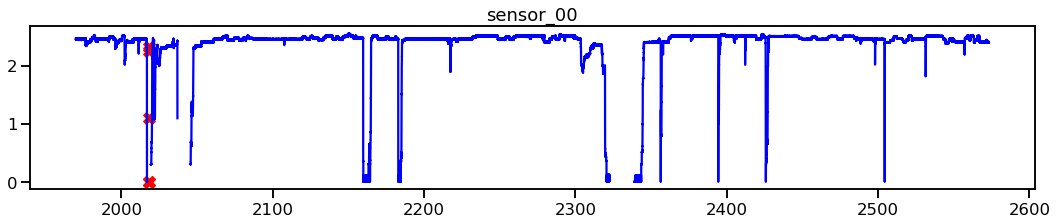

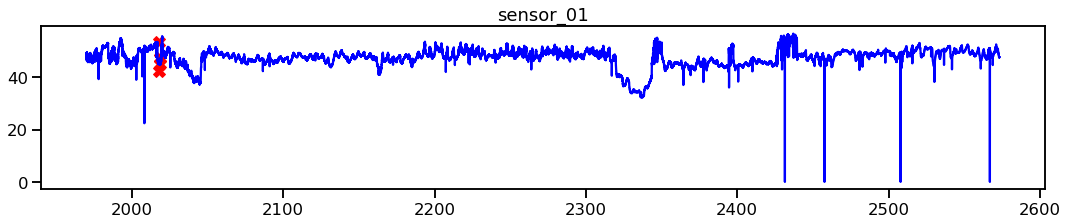

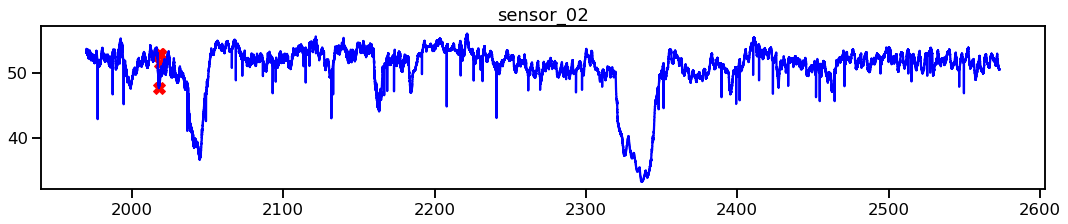

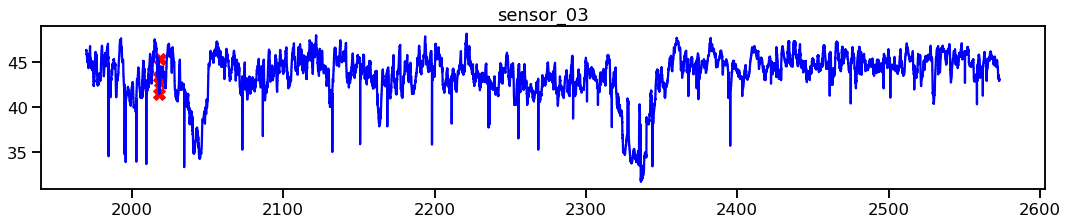

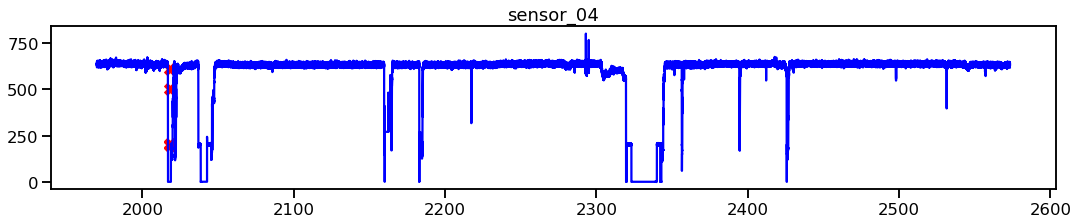

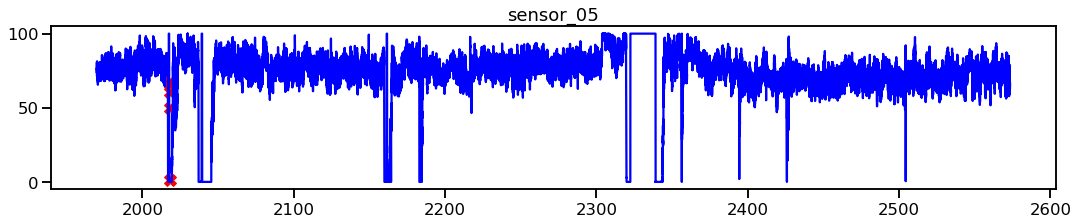

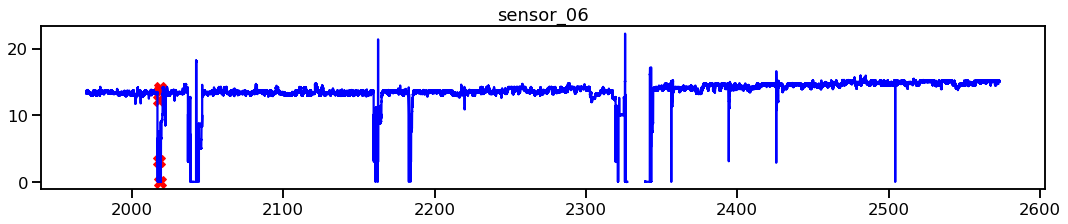

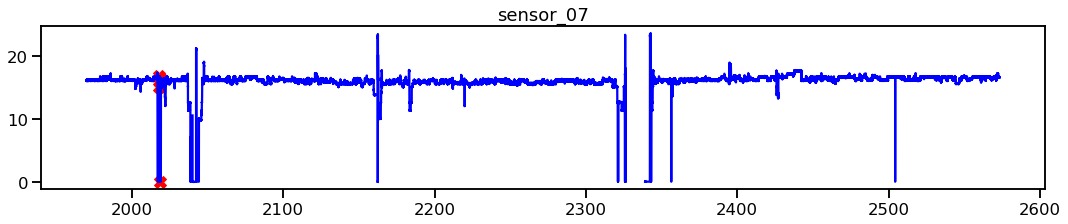

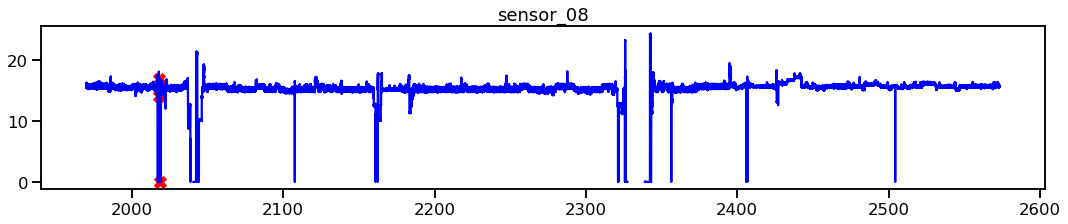

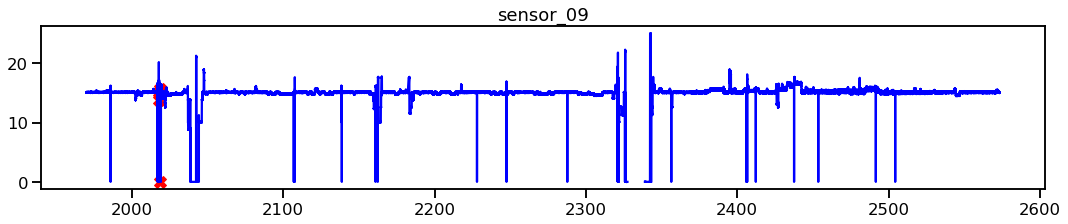

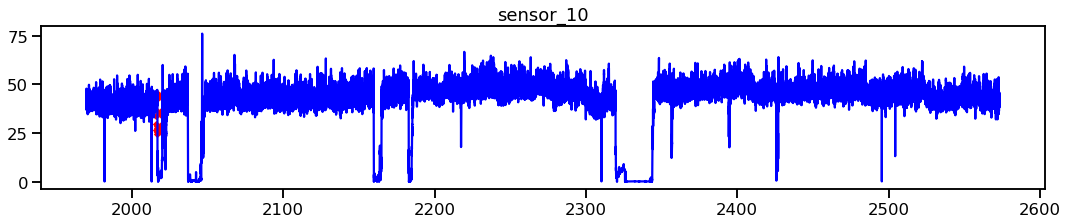

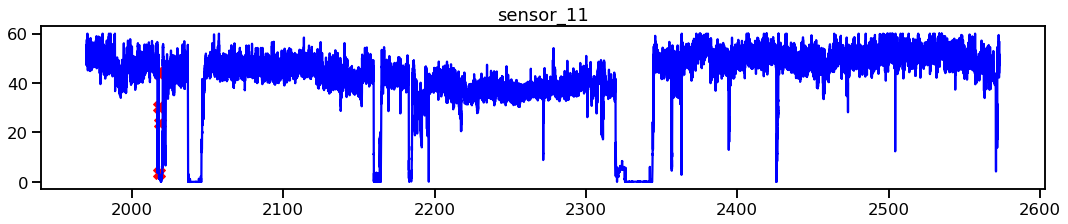

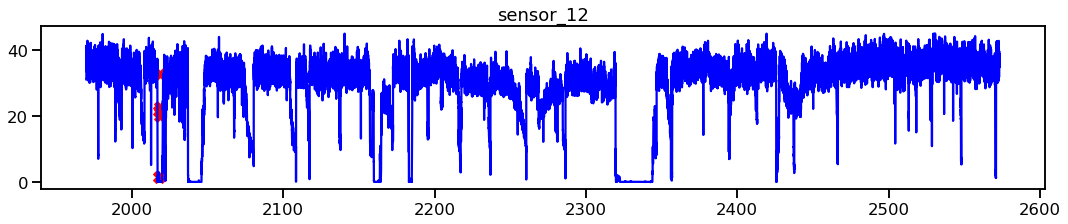

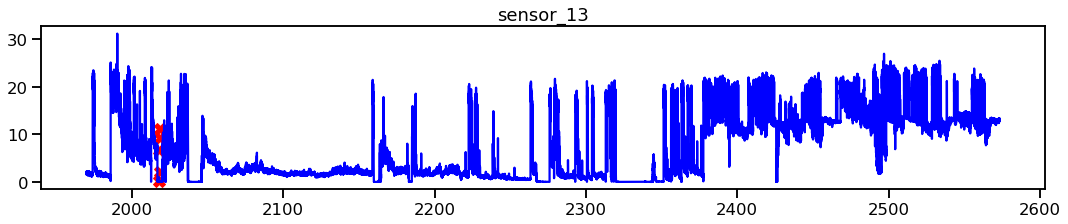

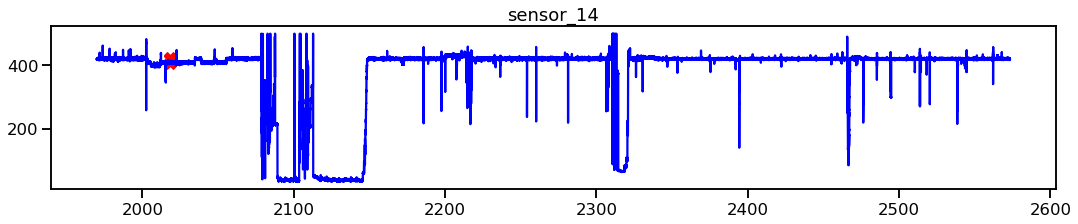

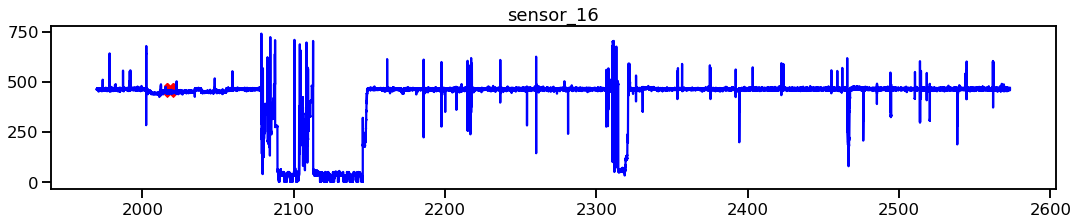

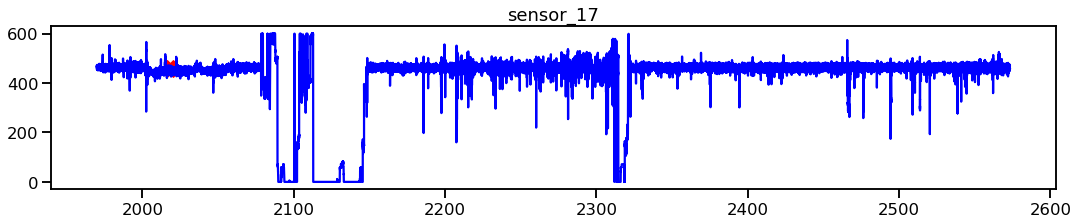

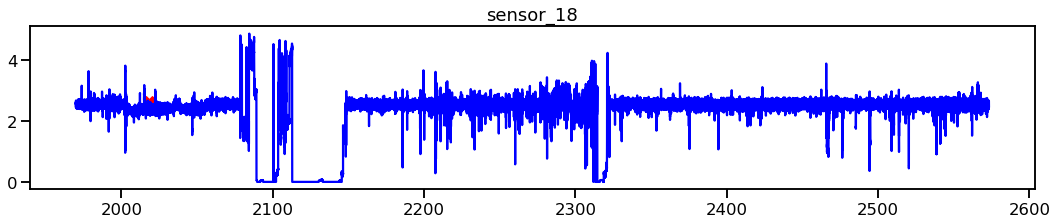

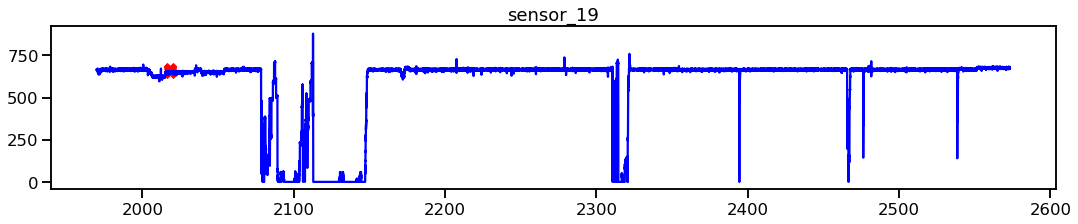

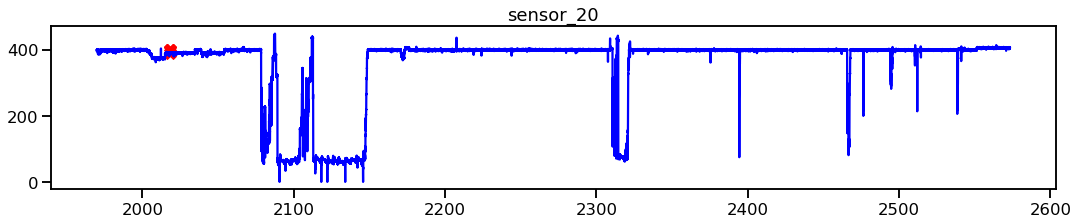

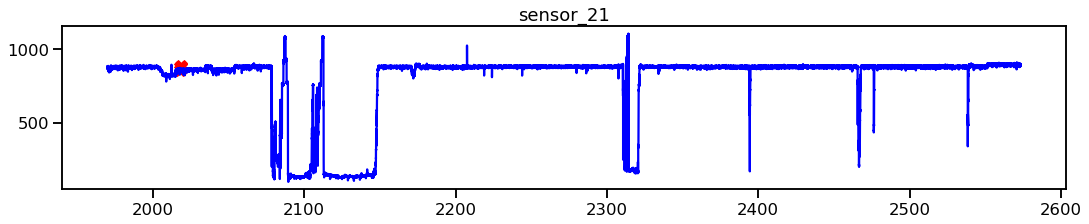

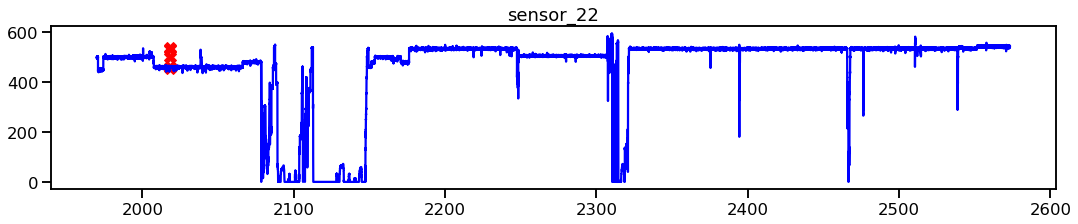

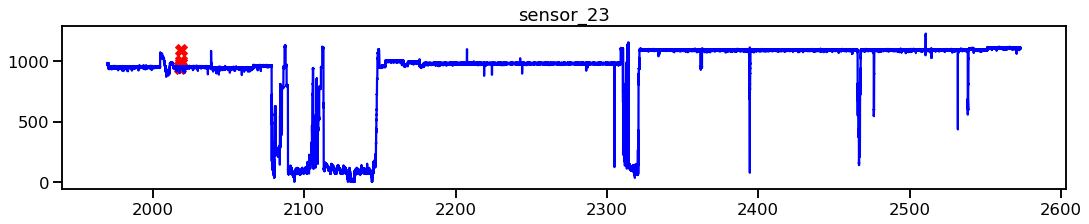

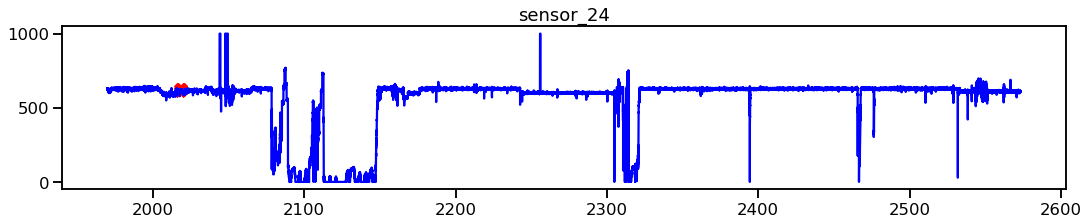

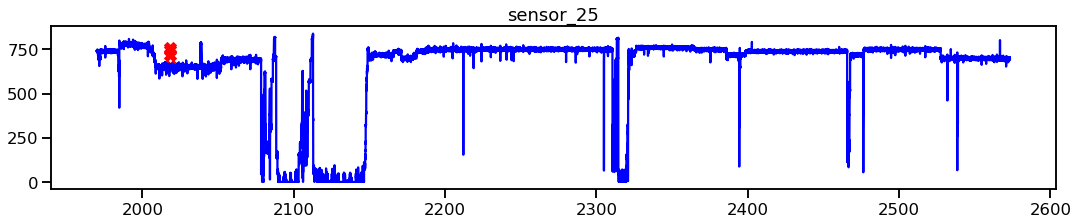

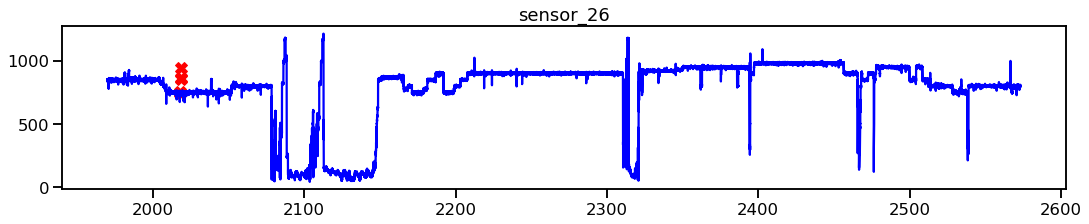

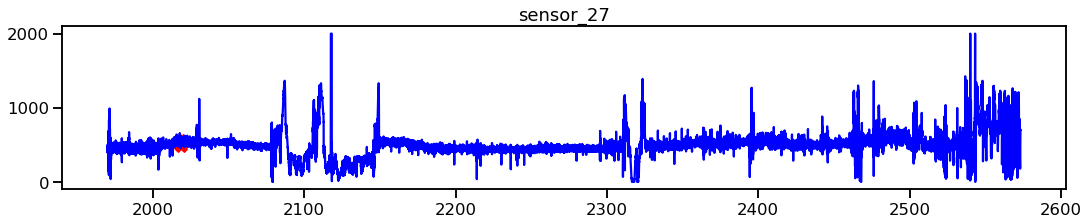

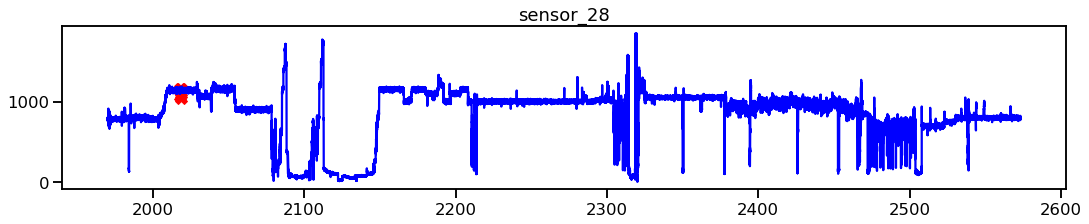

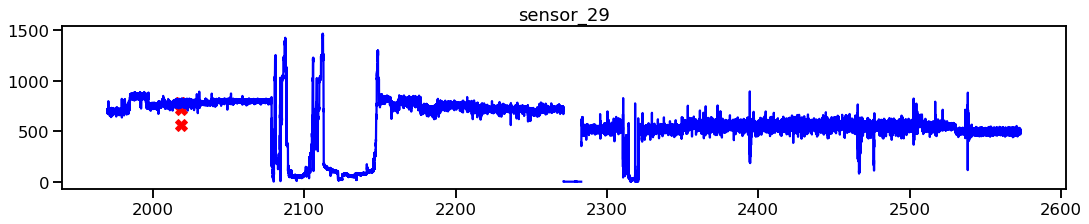

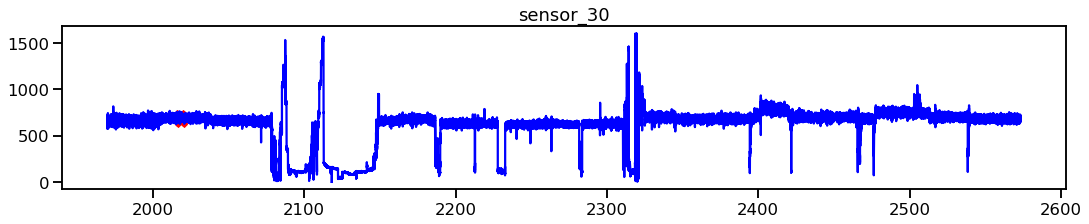

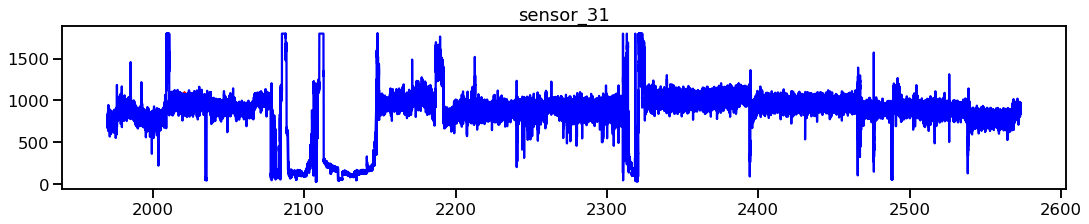

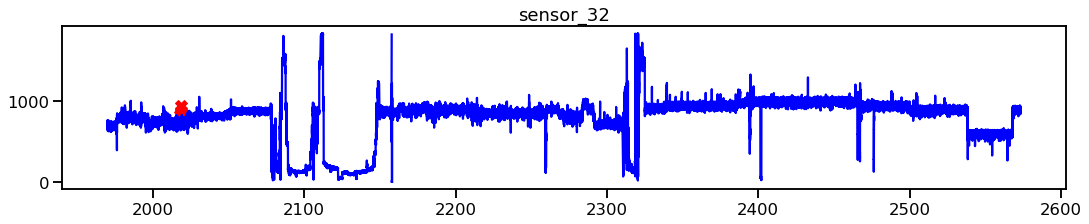

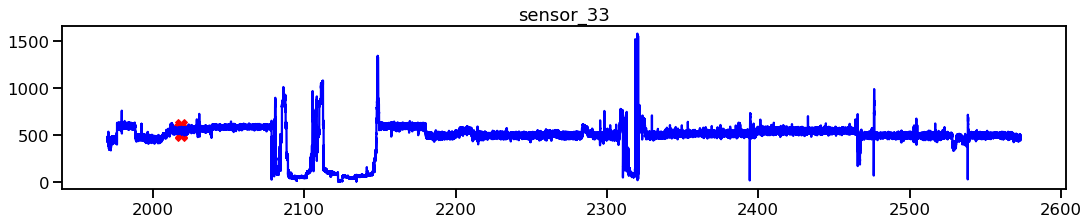

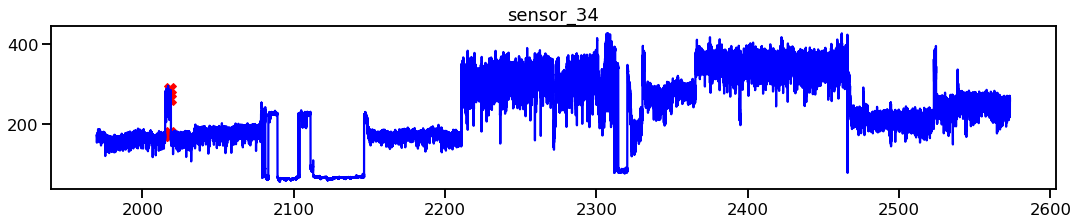

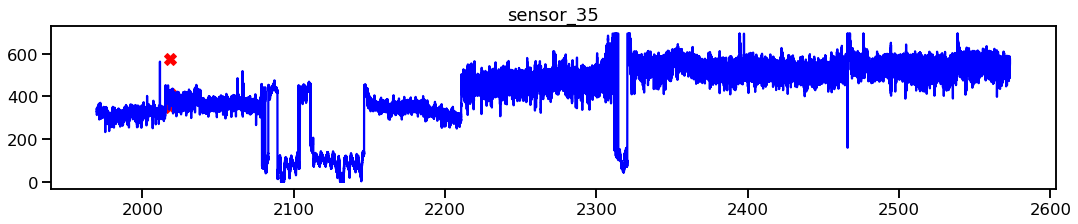

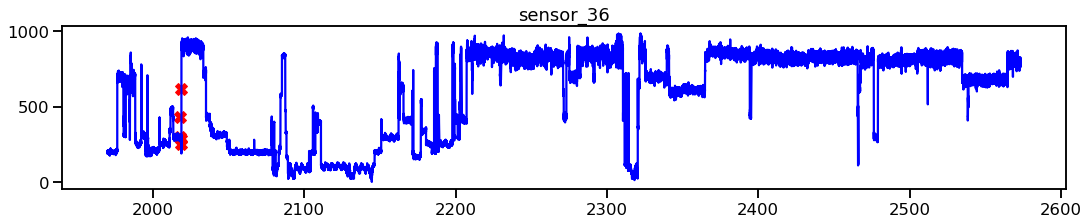

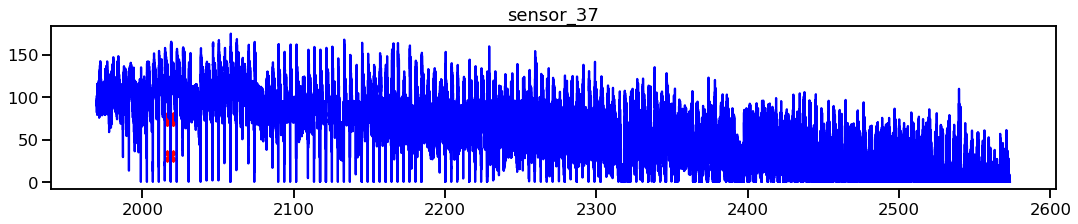

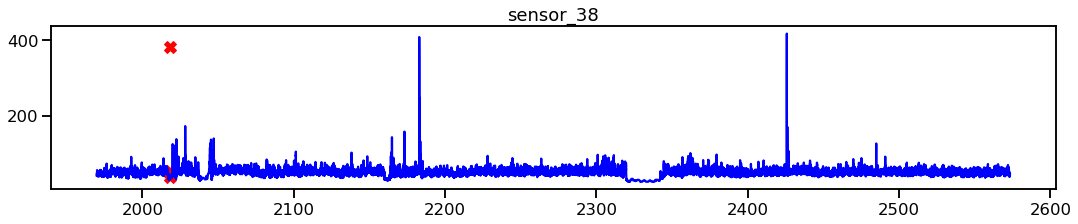

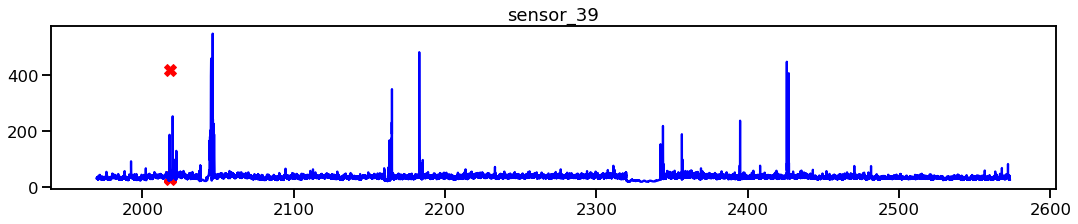

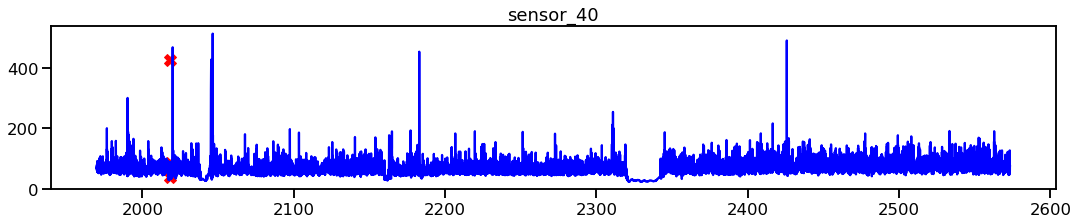

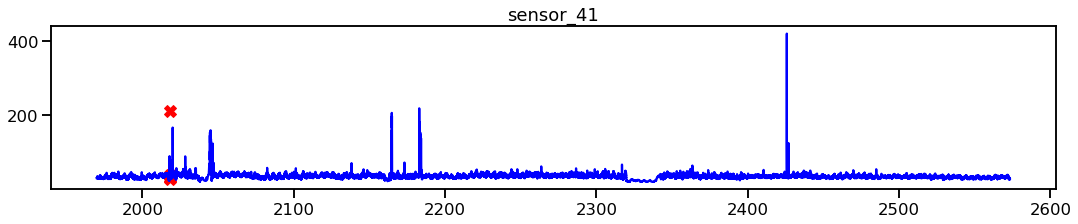

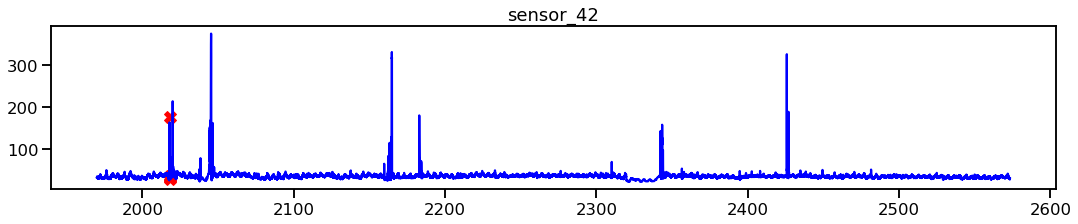

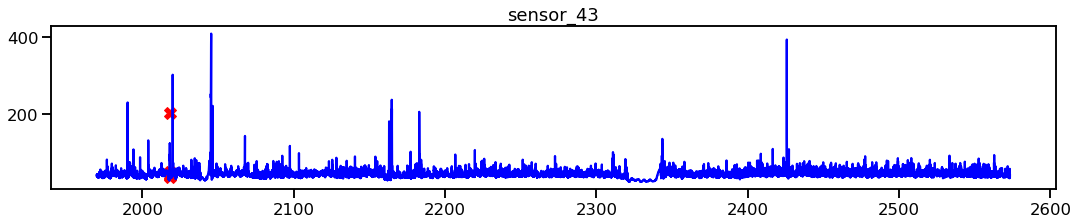

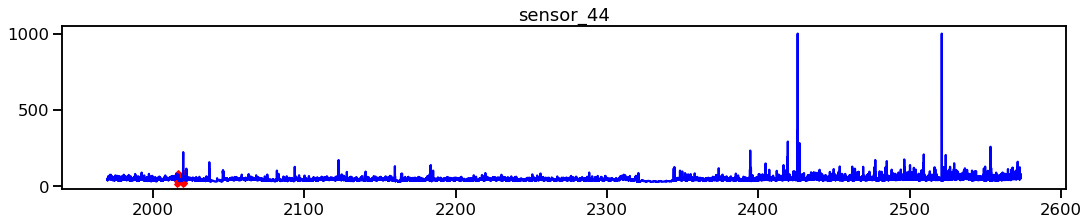

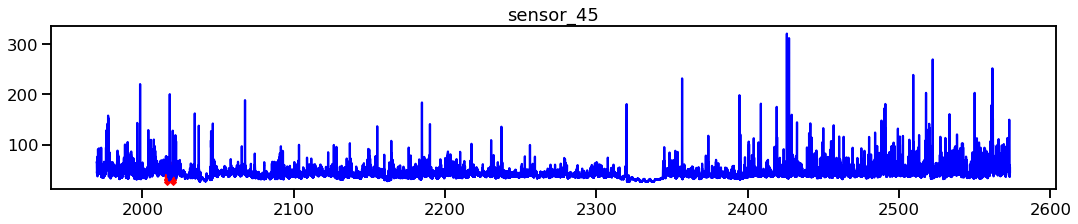

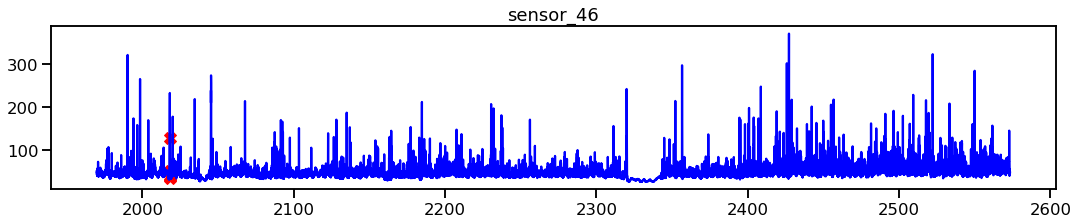

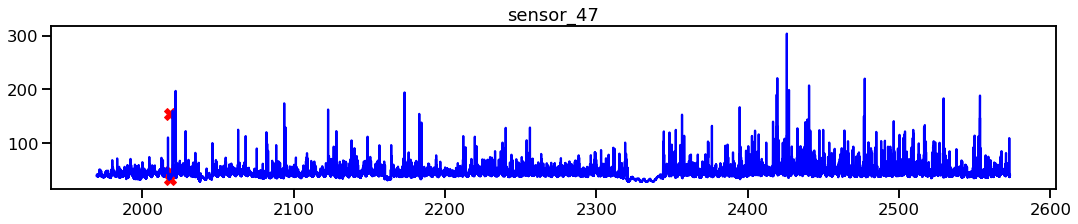

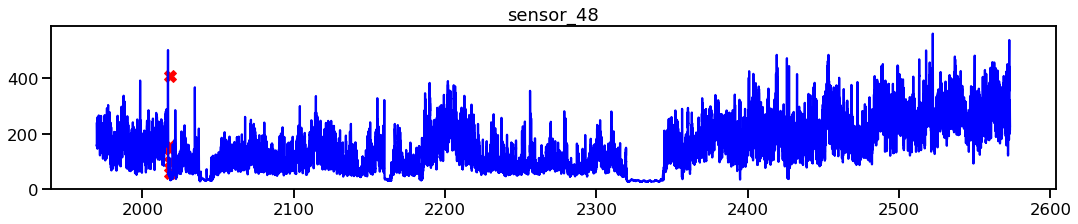

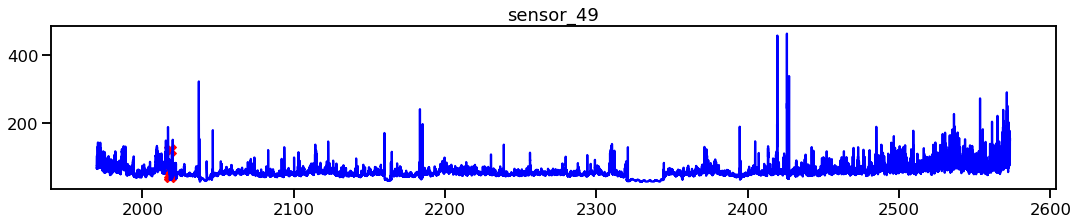

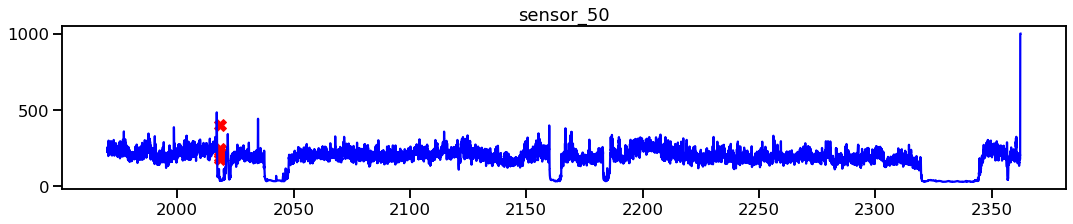

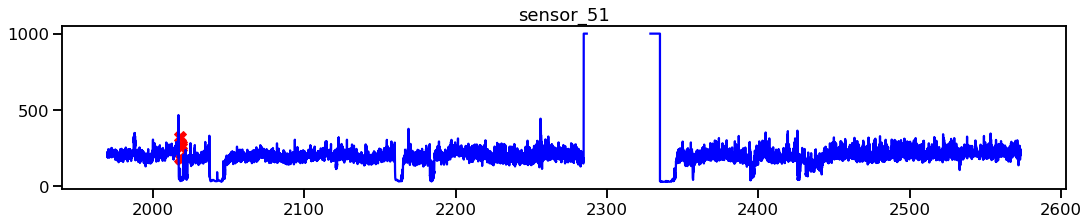

In [22]:
import warnings
# Extract the readings from BROKEN state and resample by daily average
broken = df2[df2['machine_status']=='BROKEN']
# Extract the names of the numerical columns
df3 = df2.drop(['machine_status'], axis=1)
names=df3.columns
# Plot time series for each sensor with BROKEN state marked with X in red color
for name in names:
    sns.set_context('talk')
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(broken[name], linestyle='none', marker='X', color='red', markersize=12)
    _ = plt.plot(df[name], color='blue')
    _ = plt.title(name)
    plt.show()

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# Extract the names of the numerical columns
df3 = df2.drop(['machine_status'], axis=1)
names=df3.columns
x = df2[names]
# x = x.dropna()
scaler = StandardScaler()
pca = PCA()
scaler.fit(x)
pca.fit(x)

PCA()

In [17]:
df2.shape

(119103, 52)

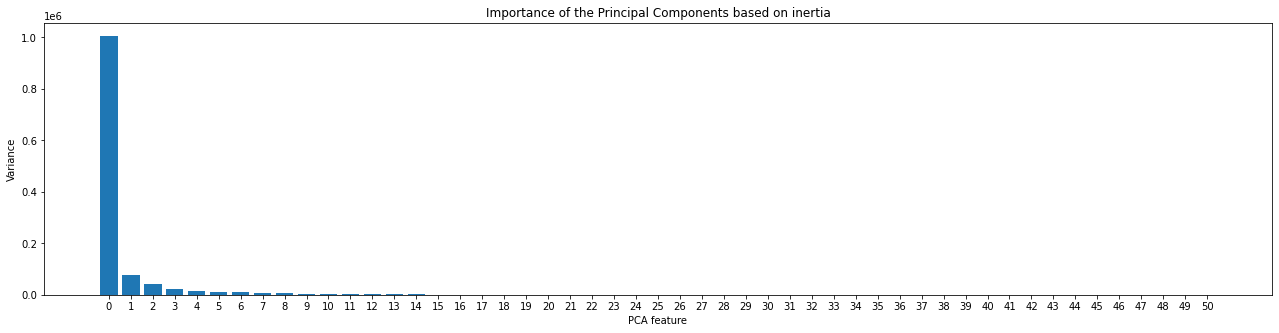

In [13]:
features = range(pca.n_components_)
_ = plt.figure(figsize=(22, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on inertia")
plt.show()

In [14]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [19]:
df2['pc1']=pd.Series(principalDf['pc1'].values, index=df2.index)
df2['pc2']=pd.Series(principalDf['pc2'].values, index=df2.index)

In [20]:
from statsmodels.tsa.stattools import adfuller
# Run Augmented Dickey Fuller Test
result = adfuller(principalDf['pc1'])
# Print p-value
print(result[1])

0.042611712055501266


In [21]:
# Run Augmented Dickey Fuller Test
result = adfuller(principalDf['pc2'])
# Print p-value
print(result[1])

6.692823214954094e-05


In [22]:
pca1 = principalDf['pc1'].pct_change()
# Compute autocorrelation
autocorrelation = pca1.dropna().autocorr()
print('Autocorrelation is: ', autocorrelation)


Autocorrelation is:  -0.041245017279783004


In [23]:
# Compute change in daily mean 
pca2 = principalDf['pc2'].pct_change()
# Compute autocorrelation
autocorrelation = pca2.autocorr()
print('Autocorrelation is: ', autocorrelation)


Autocorrelation is:  -0.00029928740017842915


### Modelling

In [25]:
from sklearn.cluster import KMeans
import numpy as np
# I will start k-means clustering with k=2 as I already know that there are 3 classes of "NORMAL" vs 
# "NOT NORMAL" which are combination of BROKEN" and"RECOVERING"
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(principalDf.values)
labels = kmeans.predict(principalDf.values)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

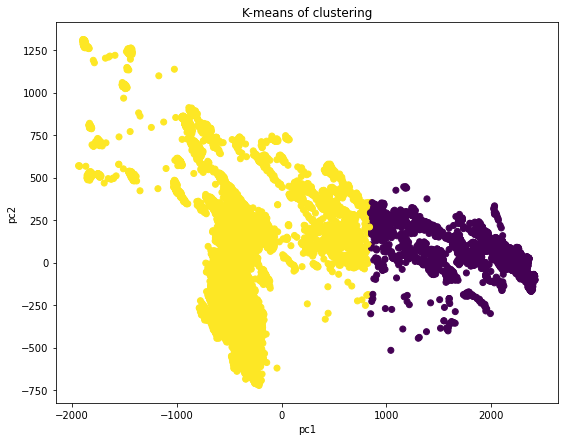

In [26]:
_ = plt.figure(figsize=(9,7))
_ = plt.scatter(principalDf['pc1'], principalDf['pc2'], c=labels)
_ = plt.xlabel('pc1')
_ = plt.ylabel('pc2')
_ = plt.title('K-means of clustering')
plt.show()

In [27]:
# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

In [28]:
# Assume that 13% of the entire data set are anomalies 
outliers_fraction = 0.13
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(principalDf, kmeans)
# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 13% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
principalDf['anomaly1'] = (distance >= threshold).astype(int)

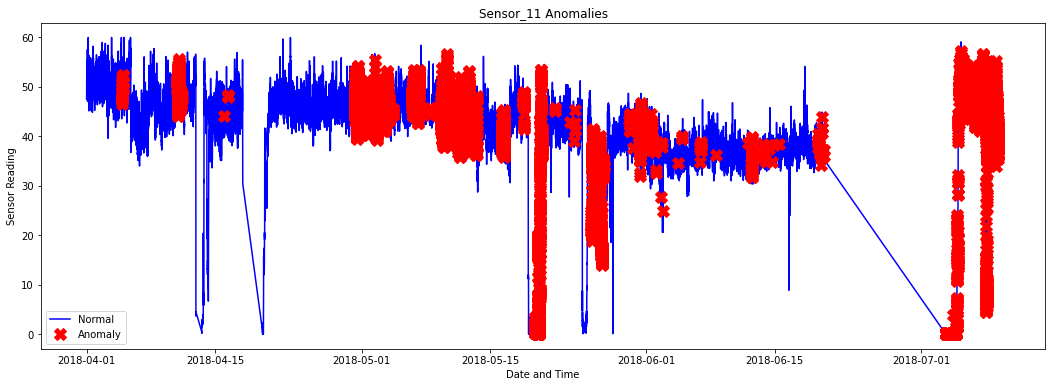

In [29]:
df2['anomaly1'] = pd.Series(principalDf['anomaly1'].values, index=df2.index)
a = df2[df2['anomaly1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df2['sensor_11'], color='blue', label='Normal')
_ = plt.plot(a['sensor_11'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_11 Anomalies')
_ = plt.legend(loc='best')
plt.show();

In [30]:
# Import IsolationForest
from sklearn.ensemble import IsolationForest
# Assume that 13% of the entire data set are anomalies 
outliers_fraction = 0.13
model =  IsolationForest(contamination=outliers_fraction)
model.fit(principalDf.values) 
principalDf['anomaly2'] = pd.Series(model.predict(principalDf.values))

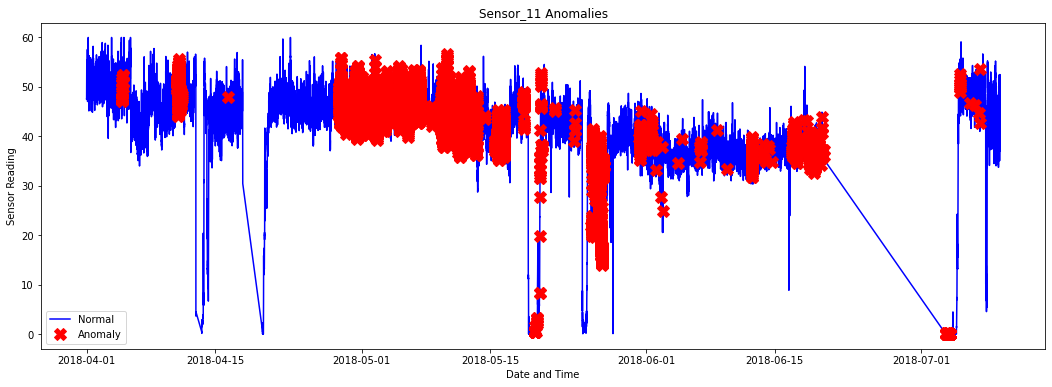

In [33]:
# visualization
df2['anomaly2'] = pd.Series(principalDf['anomaly2'].values, index=df2.index)
a = df2.loc[df2['anomaly2'] == -1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df2['sensor_11'], color='blue', label='Normal')
_ = plt.plot(a['sensor_11'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_11 Anomalies')
_ = plt.legend(loc='best')
plt.show();

### Config 

In [29]:
config = {
    "data_loader":{
        "engine":"training",
        "data_path":"../Data/sensor.csv"
    },
    "data_preprocessor":{
        "engine":"training",
        "time_col":"timestamp",
        "output_path":"../Data/preprocessed_data.csv"
    },
    "scaler":{
        "engine":"training",
        "type":"StandardScaler",
        "time_col":"date",
        "drop_cols":"machine_status"
    },
    "decomposer":{
        "engine":"training",
        "type":"PCA"
    },
    "sensor_state_cluster":{
        "engine":"training",
        "type":"KMeans",
        "n_clusters":2,
        "base_data_path":"../Data/preprocessed_data.csv",
        "plot_anomalies" : "False"
    }
}

## Classes

In [23]:
class SensorLoader:
    
    def __init__(self,):
        pass

    def load_data(self,config=config):
        
        config = config["data_loader"]
        if config["engine"] == "training":
            df = pd.read_csv(config["data_path"],index_col=[0])
            df = df.drop_duplicates()
        else:
            ## Placeholder for inference logic 
            pass
        
        return df

# sl = SensorLoader()
# loaded_data = sl.load_data(config)

In [28]:
class SensorPreprocessor:
    
    def __init__(self,):
        pass
    
    def _calc_percent_NAs(self,df):
        
        nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
        idx = nans['percent'] > 0
        return nans[idx]

    def drop_sensors(self,df):
    
        missing_perc_df = self._calc_percent_NAs(df).reset_index()
        missing_perc_df.columns = ["sensor","percent"]
        missing_perc_df = missing_perc_df[missing_perc_df["percent"]>0.80]
        
        sensors_to_be_removed = list(missing_perc_df["sensor"].unique()) 
        
        df2 = df.copy()
        for sensor in sensors_to_be_removed:
            
            del df2[sensor]
            
        df2 = df2.dropna()
        
        return df2
          
    def preprocess_data(self,config, input_df):
        
        config = config["data_preprocessor"]
        
        df = input_df 
        df['date'] = pd.to_datetime(df[config["time_col"]])
        df.drop(columns = [config["time_col"]])
        
        if config["engine"] == "training":
            preprocessed_df = self.drop_sensors(df)
            del preprocessed_df["timestamp"]
            
        else:
            ## Placeholder for inference logic 
            pass
        
        preprocessed_df.to_csv(config["output_path"])
        
        return preprocessed_df
        
        
sp = SensorPreprocessor()
# preprocessed_data = sp.preprocess_data(config,loaded_data)       
# preprocessed_data

In [25]:
class Scaler:
    
    def __init__(self,):
        pass
    
    def scale_features(self,config,input_df):
        
        config = config["scaler"]
        input_df = input_df.set_index(config["time_col"])
        input_df = input_df.drop(columns = [config["drop_cols"]])
        scaler = config["type"]
        
        if config["engine"] == "training":
            if scaler == "StandardScaler":
                sc = StandardScaler()
        
            scaled_df = input_df.copy() 
            sc.fit(scaled_df)
            
        else:
            ### Incase of inference the saved model will be loaded and the scaled df will be generated
            pass
        
        return scaled_df
    
# sc = Scaler()
# scaled_df=sc.scale_features(config,preprocessed_data)

In [32]:
class FeatureDecomposer:
    
    def __init__(self):
        pass
    
    def decompose_features(self,config,input_df):
        
        config = config["decomposer"]
        decomposer = config["type"]
        
        if config["engine"] == "training":
            if decomposer == "PCA":            
                pca = PCA(n_components=2)
                principalComponents = pca.fit_transform(input_df)
                principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
        else:
            ## Here the saved pca model will be loaded for inerence
            pass
            
        return principalDf
        
# dc = FeatureDecomposer()
# decomposed_features = dc.decompose_features(config,scaled_df)

In [36]:
class SensorStateClusterGenerator:
    
    def __init__(self,):
        pass
    
    # Write a function that calculates distance between each point and the centroid of the closest cluster
    def _getDistanceByPoint(self,data, model):
        """ Function that calculates the distance between a point and centroid of a cluster, 
                returns the distances in pandas series"""
        distance = []
        for i in range(0,len(data)):
            Xa = np.array(data.loc[i])
            Xb = model.cluster_centers_[model.labels_[i]-1]
            distance.append(np.linalg.norm(Xa-Xb))
        return pd.Series(distance, index=data.index)
    
    def get_anomaly_label(self,config , model):
        
        outliers_fraction = 0.13
        distance = self._getDistanceByPoint(self.input_df, model)
        number_of_outliers = int(outliers_fraction*len(distance))
        threshold = distance.nlargest(number_of_outliers).min()
        
        # anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
        self.input_df['anomaly_label'] = (distance >= threshold).astype(int)
            
    def kmeans(self,config,input_df):
        
        logger = MLflowLogger("test_exp","test_run")
        kmeans = KMeans(n_clusters=config["sensor_state_cluster"]["n_clusters"], random_state=42)
        kmeans.fit(input_df.values)
        labels = kmeans.predict(input_df.values)
        unique_elements, counts_elements = np.unique(labels, return_counts=True)
        clusters = np.asarray((unique_elements, counts_elements))
        
        
        logger.log_params({
            "n_cluster" : config["sensor_state_cluster"]["n_clusters"]
        })
        
        return kmeans , clusters
        
    
    def generate_cluster(self,config,input_df):
        
        cluster = config["sensor_state_cluster"]["type"]
        self.input_df = input_df
        
        if cluster == "KMeans":
            model , clusters = self.kmeans(config,input_df)
            
        self.get_anomaly_label(config , model)
        base_data = pd.read_csv(config["sensor_state_cluster"]["base_data_path"])
        base_data["anomaly_label"] = self.input_df["anomaly_label"]
        
        feats = []
        for i in list(base_data.columns):
            if "sensor" in i:
                feats.append(i)
        
        
        if config["sensor_state_cluster"]["plot_anomalies"] == "True":
            
            viz = DataVisualizer()
            for sensor in feats:
                viz.plot_sensor_anomalies(base_data , sensor , 1)           
        
        return base_data

# scg = SensorStateClusterGenerator()
# labels = scg.generate_cluster(config,decomposed_features)

In [10]:
class DataVisualizer:
    
    def __init__(self,):
        pass
        
    def plot_sensor_anomalies(self, data , sensor_name , anomaly_label):
        
        a = data[data['anomaly_label'] == anomaly_label] #anomaly
        _ = plt.figure(figsize=(18,6))
        _ = plt.plot(data[sensor_name], color='blue', label='Normal')
        _ = plt.plot(a[sensor_name], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
        _ = plt.xlabel('Date and Time')
        _ = plt.ylabel('Sensor Reading')
        _ = plt.title(sensor_name + 'Anomalies')
        _ = plt.legend(loc='best')
        plt.show();


In [11]:
recipe = {
    "data_loader" : {
        "module" : "SensorLoader",
        "upstream" : [] ,
        "env" : "CPU",
        "memory" : "16g",
        "cores" : 4
    },    
    "data_preprocessor" : {
        "module" : "SensorPreprocessor",
        "upstream" : ["data_loader"] ,
        "env" : "CPU",
        "memory" : "16g",
        "cores" : 4
    },
    "scaler" : {
        "module" : "Scaler",
        "upstream" : ["data_preprocessor"] ,
        "stage" : "Training",
        "env" : "GPU",
        "memory" : "16g",
        "cores" : 4
    },
    "decomposer" : {
        "module" : "FeatureDecomposer",
        "upstream" : ["scaler"] ,
        "env" : "CPU",
        "memory" : "16g",
        "cores" : 4
    },
    "cluster_generator" : {
        "module" : "SensorStateClusterGenerator",
        "upstream" : ["decomposer"] ,
        "env" : "CPU",
        "memory" : "16g",
        "cores" : 4
    },
}

In [37]:
import sys
class AnomalyDetector:
    
    def __init__(self, recipe):
        
        self.data_loader = recipe["data_loader"]["module"]
        self.data_preprocessor = recipe["data_preprocessor"]["module"]
        self.scaler = recipe["scaler"]["module"]
        self.decomposer = recipe["decomposer"]["module"]
        self.cluster_generator = recipe["cluster_generator"]["module"]
    
    def build(self,):
        
        self.data_loader = getattr( sys.modules[__name__] , self.data_loader)
        self.data_preprocessor = getattr( sys.modules[__name__] , self.data_preprocessor)
        self.scaler = getattr( sys.modules[__name__] , self.scaler)
        self.decomposer = getattr( sys.modules[__name__] , self.decomposer)
        self.cluster_generator = getattr( sys.modules[__name__] , self.cluster_generator)
        
    
    def run(self,config):
        
        self.build()
        
        loaded_data = self.data_loader().load_data(config)
        preprocessed_data = self.data_preprocessor().preprocess_data(config , loaded_data)
        scaled_feats = self.scaler().scale_features(config,preprocessed_data)
        decomposed_feats = self.decomposer().decompose_features(config,scaled_feats)
        labelled_data = self.cluster_generator().generate_cluster(config,decomposed_feats)
        
        return labelled_data

In [38]:
%%time
ad = AnomalyDetector(recipe)
ad.run(config)

2021/04/30 07:49:26 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



INFO: 'test_exp' does not exist. Creating a new experiment
MLFLOW is initialized
Wall time: 19.9 s


,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status,date,anomaly_label
0,0,2.465394,47.092010,53.21180,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,65.68287,50.92593,38.194440,157.9861,67.708340,243.0556,201.3889,NORMAL,2018-04-01 00:00:00,0
1,1,2.465394,47.092010,53.21180,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,65.68287,50.92593,38.194440,157.9861,67.708340,243.0556,201.3889,NORMAL,2018-04-01 00:01:00,0
2,2,2.444734,47.352430,53.21180,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,65.39352,51.21528,38.194443,155.9606,67.129630,241.3194,203.7037,NORMAL,2018-04-01 00:02:00,0
3,3,2.460474,47.092010,53.16840,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,64.81481,51.21528,38.194440,155.9606,66.840280,240.4514,203.1250,NORMAL,2018-04-01 00:03:00,0
4,4,2.445718,47.135410,53.21180,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,65.10416,51.79398,38.773150,158.2755,66.550930,242.1875,201.3889,NORMAL,2018-04-01 00:04:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119098,143319,2.474248,45.138885,51.86632,46.440970,636.5741,85.04365,13.77315,16.03733,15.18374,...,42.53472,58.44907,43.981480,169.8495,53.530094,1000.0000,202.8356,NORMAL,2018-07-09 12:39:00,0
119099,143320,2.476215,45.138890,51.86632,46.440971,621.7593,84.11448,13.89612,16.24711,15.45139,...,42.53472,57.87037,45.138890,169.8495,53.530094,1000.0000,201.0995,NORMAL,2018-07-09 12:40:00,0
119100,143321,2.468345,45.182290,51.82291,46.440971,626.2731,84.99566,13.92506,16.13136,15.37182,...,42.24537,56.42361,46.296300,167.8241,53.530094,1000.0000,200.8102,NORMAL,2018-07-09 12:41:00,0
119101,143322,2.479167,45.138890,51.86632,46.440971,631.9445,85.67138,13.78038,16.24711,14.96672,...,42.53472,54.97685,47.743060,162.6157,53.530094,1000.0000,199.9421,NORMAL,2018-07-09 12:42:00,0


In [35]:
import mlflow
class MLflowLogger:
    
    def __init__(self,experiment_name , run_name):
        
        self.experiment_name = experiment_name
        self.run_name = run_name + "____" + str(datetime.datetime.now()) 
        mlflow.set_experiment(experiment_name=self.experiment_name)
        with mlflow.start_run():
            print("MLFLOW is initialized")
            
            
    def log_params(self,param_dict):
        
        with mlflow.start_run(nested = True , run_name= self.run_name):
            mlflow.log_params(param_dict)
            mlflow.end_run()
    